<a href="https://colab.research.google.com/github/Anupa-123/Twitter_sentiment_analysis/blob/main/Twitter_sentiment__analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install secret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 72.5 MB/s eta 0:00:00
  Created wheel for secret: filename=secret-0.8-py3-none-any.whl size=9099 sha256=f7fbac03be487915c094e70ffa3fa6fd40729d76db869b85165dc556a199b4d3
  Stored in directory: /root/.cache/pip/wheels/58/aa/49/392eef7d8ce149344fbacfeebff380a525cdd552d18c88ee8d
Successfully built secret


In [2]:
pip install pycurl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.2/234.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycurl: filename=pycurl-7.45.2-cp39-cp39-linux_x86_64.whl size=334181 sha256=6dfacb0a8b62bd17a3b9dd895cc5802663797803d859e0702c9f5e6df72cd10e
  Stored in directory: /root/.cache/pip/wheels/23/b0/37/d2c3211ee738adfb8ec6b6e10aa00e78ebc4de363f862a12c5
Successfully built pycurl


In [3]:
pip install oauth2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install twitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00


In [6]:
pip install *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.0/971.0 kB 10.1 MB/s eta 0:00:00


In [7]:
from flask import Flask
from flask import Flask, flash, redirect, render_template, request, session, abort
from flask import Markup
import os

In [8]:

app = Flask(__name__)
app.config['SESSION_TYPE'] = 'filesystem'
app.config['SECRET_KEY'] = 'reds209ndsldssdsljdsldsdsljdsldksdksdsdfsfsfsfis'
#session.init_app(app)

In [9]:

positive = 0
negative = 0
neutral = 0

In [10]:
@app.route('/')
def home():
    if not session.get('searched'):
        return render_template('search.html')
    else:
        labels = ["Positive", "Negative", "Neutral"]
        global positive
        global negative
        global neutral
        values = [positive, negative, neutral]
        colors = ["#8bc34a", "#ff5252", "#9e9e9e"]
        session['searched'] = False
        return render_template('chart.html', set=zip(values, labels, colors))

In [11]:
@app.route('/search', methods=['POST'])
def do_search():
    if request.form['search_query'] == '':
        flash('Search Queary cannot be empty!')
        session['searched'] = False
    if request.form['max_tweets'] == '':
        flash('Max Tweets cannot be empty!')
        session['searched'] = False
    else:
        if not request.form['max_tweets'].isdigit():
            flash('Max Tweets should be a number!')
            session['searched'] = False
        else:
            if int(request.form['max_tweets']) > 0 & int(request.form['max_tweets']) <= 100000:
                import tweepy
                import sys
                import csv
                import pickle
                from nltk.sentiment.vader import SentimentIntensityAnalyzer
                from collections import Counter

                # importing the auth variables from secret.py
                import secret

                # authenicating with authentication variables
                auth = tweepy.OAuthHandler(secret.consumer_key, secret.consumer_secret)
                auth.set_access_token(secret.access_token, secret.access_token_secret)
                api = tweepy.API(auth, wait_on_rate_limit=True,
                                 wait_on_rate_limit_notify=True)
                # Error handling
                if (not api):
                    print("Problem Connecting to API")

                # inputs for counts taken
                hash_tag = request.form['search_query']
                number = int(request.form['max_tweets'])
                # location = input("What is the location of party? \n")

                # # Getting Geo ID for Places
                # places = api.geo_search(query=location)
                # # place id
                # print(places[0])

                tweetsPerQry = 100  # this is the max the API permits

                # If results from a specific ID onwards are reqd, set since_id to that ID.
                # else default to no lower limit, go as far back as API allows
                sinceId = None

                # If results only below a specific ID are, set max_id to that ID.
                # else default to no upper limit, start from the most recent tweet matching the search query.
                max_id = -1
                data = None

                dataset = []
                outputFile = 'test.data'
                fw = open(outputFile, 'wb')

                tweetCount = 0
                print("Downloading max {0} tweets".format(number))
                while tweetCount < number:
                    try:
                        if (max_id <= 0):
                            if (not sinceId):
                                new_tweets = api.search(q=hash_tag, count=tweetsPerQry, tweet_mode='extended', lang='en')
                                tweetCount += len(new_tweets)
                                print("Downloaded {0} tweets".format(tweetCount))
                            else:
                                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                                        since_id=sinceId, tweet_mode='extended', lang='en')
                                print("here 2")
                        else:
                            if (not sinceId):
                                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                                        max_id=str(max_id - 1), tweet_mode='extended', lang='en')
                                print("here 3")
                            else:
                                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                                        max_id=str(max_id - 1),
                                                        since_id=sinceId, tweet_mode='extended', lang='en')
                                print("here 4")
                            if not new_tweets:
                                print("No more tweets found")
                                break

                        # print(new_tweets)

                        tweets = new_tweets
                        for tweet in tweets:
                            dataset.append(tweet.full_text)
                        #data += pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
                        tweetCount += len(new_tweets)
                        print("Downloaded {0} tweets".format(tweetCount))
                        max_id = new_tweets[-1].id
                    except tweepy.TweepError as e:
                        print(str(e))
                        break
                    
                pickle.dump(dataset, fw)
                fw.close()

                inputFile = 'test.data'
                fd = open(inputFile, 'rb')
                dataset = pickle.load(fd)
                print(dataset)



In [ ]:
 # search tweets with some keywords
                # results = api.search(hash_tag,
                #                      count=number,
                #                      since="2019-03-04",
                #                    until="2019-03-05",
                #                      tweet_mode='extended',
                #                      lang='en',
                #                      place=places[0].id
                #                      )

                # print (results)

                # tweets = results
                # data = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])
                # data.to_csv('output.csv')

                # print the first 10 data
                # print(data)

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from collections import Counter

def home():
    pass

sid = SentimentIntensityAnalyzer()
dataset = ["I love this product!", "This product is terrible.", "This product is just okay."]
l = []
counter = Counter()
for data in dataset:
    ss = sid.polarity_scores(data)
    l.append(ss)
    k = ss['compound']
    if k >= 0.05:
        counter['positive'] += 1
    elif k <= -0.05:
        counter['negative'] += 1
    else:
        counter['neutral'] += 1

positive = counter['positive']
negative = counter['negative']
neutral = counter['neutral']

app.secret_key = 'abcdefghijk'

if __name__ == "__main__":
    #session['searched'] = True
    app.run(debug=True, host='0.0.0.0', port=4000)



 * Serving Flask app '__main__'
 * Debug mode: on


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:4000
 * Running on http://172.28.0.12:4000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [13]:
import config

In [14]:
import tweepy
import pandas as pd
import sys
import csv
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from collections import Counter

In [15]:
if sys.version_info[0] < 3:
    input = raw_input

In [16]:
import tweepy
import time
import pycurl
import urllib
import json
import oauth2 as oauth

In [17]:
# importing the auth variables from secret.py
import secret

In [18]:
import twitter

In [19]:
import sys
sys.path.append("/path/to/config.config/module")


In [20]:
#from config.config import consumer_secret, consumer_key, secret, token
import tweepy
from tweepy.auth import OAuthHandler
from tweepy import API
from tweepy import OAuthHandler

In [21]:
import tweepy
consumer_key = 'your_consumer_key'
consumer_secret = 'your_consumer_secret'
access_token = 'your_access_token'
access_token_secret = 'your_access_token_secret'

# Authenicating with authentication variables
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth=None, cache=None, host='api.twitter.com', parser=None, 
                 proxy=None, retry_count=0, retry_delay=0, retry_errors=None, 
                 timeout=60, upload_host='upload.twitter.com', user_agent=None, wait_on_rate_limit=False)

# Error handling
try:
    api.verify_credentials()
    print("Authentication OK")
except Exception as e:
    print("Error during authentication:", str(e))
    exit()

Error during authentication: Authentication required!


In [1]:
# inputs for counts taken
hash_tag = input("Which party you want to search ? \n")
number = int(input("How many Tweets do you want to analyze? \n"))
location = input("What is the location of party? \n")

# Getting Geo ID for Places
places = api.geo_search(query=location)
# place id
print(places[0])

Which party you want to search ? 
bjp
How many Tweets do you want to analyze? 
30
What is the location of party? 
mumbai


NameError: ignored

In [2]:

tweetsPerQry = 100  # this is the max the API permits

In [3]:
# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

In [4]:
# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1
data = None

dataset = []
outputFile = 'test.data'
fw = open(outputFile, 'wb')

In [5]:
tweetCount = 0
print("Downloading max {0} tweets".format(number))
while tweetCount < number:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=hash_tag, count=tweetsPerQry, tweet_mode='extended', lang='en')
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
            else:
                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                        since_id=sinceId, tweet_mode='extended', lang='en')
                print("here 2")
        else:
            if (not sinceId):
                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                        max_id=str(max_id - 1), tweet_mode='extended', lang='en')
                print("here 3")
            else:
                new_tweets = api.search(q=hash_tag, count=tweetsPerQry,
                                        max_id=str(max_id - 1),
                                        since_id=sinceId, tweet_mode='extended', lang='en')
                print("here 4")
            if not new_tweets:
                print("No more tweets found")
                break

        # print(new_tweets)

        tweets = new_tweets
        for tweet in tweets:
            dataset.append(tweet.full_text)
        #data += pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        print(str(e))
        break


pickle.dump(dataset, fw)
fw.close()

NameError: ignored

In [6]:
# search tweets with some keywords
# results = api.search(hash_tag,
#                      count=number,
#                      since="2019-03-04",
# 					 until="2019-03-05",
#                      tweet_mode='extended',
#                      lang='en',
#                      place=places[0].id
#                      )

# print (results)

# tweets = results
# data = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])
# data.to_csv('output.csv')

# print the first 10 data
# print(data)

In [7]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from collections import Counter

def home():
    pass

sid = SentimentIntensityAnalyzer()
dataset = ["I love this product!", "This product is terrible.", "This product is just okay."]


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
import matplotlib.pyplot as plt


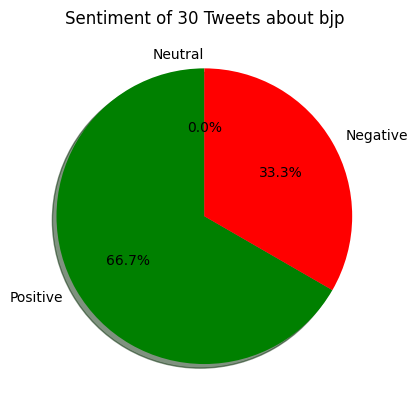

In [9]:
l = []
counter = Counter()

for data in dataset:
    ss = sid.polarity_scores(data)
    l.append(ss)
    k = ss['compound']
    if k >= 0.05:
        counter['positive'] += 1
    elif k <= -0.05:
        counter['negative'] += 1
    else:
        counter['neutral'] += 1

positive = counter['positive']
negative = counter['negative']
neutral = counter['neutral']

colors = ['green', 'red', 'grey']
sizes = [positive, negative, neutral]
labels = 'Positive', 'Negative', 'Neutral'

# use matplotlib to plot the chart
plt.pie(
    x=sizes,
    shadow=True,
    colors=colors,
    labels=labels,
    startangle=90,
    autopct='%.1f%%'
)

plt.title("Sentiment of {} Tweets about {}".format(number, hash_tag))
plt.show()